# set up

In [1]:
import os

In [2]:

os.chdir(f'../')

In [3]:
BASE_PATH = './pretrained'

In [4]:
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + '/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + '/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + '/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + '/fake/small_image/'
W_DATA_DIR = BASE_PATH + '/fake/small_w/'
MODELS_DIR = BASE_PATH + '/Models/'

In [5]:
from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss


In [6]:
print(Global_Config.device)

cuda


# network

In [7]:
id_encoder = id_loss.IDLoss('./pretrained/model_ir_se50.pth')
attr_encoder = torch.load('./pretrained/Models/attr_long1678731087.4649038_12.pt')
attr_encoder = Inception(attr_encoder)
discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE, 512, 8)

Loading ResNet ArcFace


In [8]:
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

_IncompatibleKeys(missing_keys=['noises.noise_0', 'noises.noise_1', 'noises.noise_2', 'noises.noise_3', 'noises.noise_4', 'noises.noise_5', 'noises.noise_6', 'noises.noise_7', 'noises.noise_8', 'noises.noise_9', 'noises.noise_10', 'noises.noise_11', 'noises.noise_12'], unexpected_keys=[])

In [9]:
# load our checkpoints


mlp = torch.load('pretrained/Models/maper_long1678731087.2647676_12.pt')

In [10]:
id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
generator = generator.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

In [11]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.eval()
generator = generator.eval()
mlp = mlp.eval()
landmark_encoder = landmark_encoder.eval()

# get images

In [26]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

convert_tensor = T.ToTensor()
transform = T.Resize((256,256))

test_id_images = Image.open('./Inference_Data/Anoop-Namboodiri.jpg')
test_attr_images = Image.open('./pretrained/fake/small_image/0/613.png')

id_image = transform(test_id_images)
attr_image = transform(test_attr_images)



In [27]:
def get_concat_vec(id_images, attr_images, id_encoder, attr_encoder):
    with torch.no_grad():
        id_vec = torch.squeeze(id_encoder.extract_feats((id_images*2)-1))
        attr_vec = torch.squeeze(attr_encoder(attr_images))
        test_vec = torch.cat((id_vec, attr_vec), dim=1)
        return test_vec

In [28]:

id_image1 = convert_tensor(id_image).to('cuda')
attr_image1 = convert_tensor(attr_image).to('cuda')

id1 = torch.stack((id_image1, attr_image1))
atr1 = torch.stack((attr_image1,id_image1))
id_encoder.extract_feats((id1*2)-1).shape
concat_vec_cycled = get_concat_vec(id1, atr1, id_encoder, attr_encoder)

In [29]:
idloss = id_encoder(atr1,atr1)
print(idloss)

tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


In [30]:
with torch.no_grad():
    mapped_concat_vec_cycled = mlp(concat_vec_cycled)

In [31]:

cycled_generated_image = get_w_image(mapped_concat_vec_cycled[0], generator)
cycled_generated_image1 = get_w_image(mapped_concat_vec_cycled[1], generator)



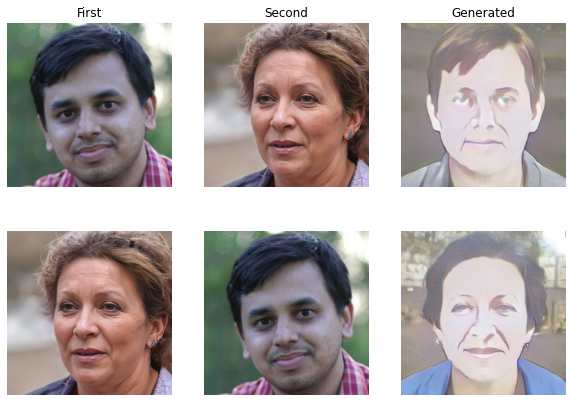

In [32]:
# Result!
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 3, 1)
  
# showing image
plt.imshow(id_image)
plt.axis('off')
plt.title("First")
# plt.save(id_image)
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 2)
  
# showing image
plt.imshow(attr_image)
plt.axis('off')
plt.title("Second")


fig.add_subplot(2, 3, 3)
plt.imshow(cycled_generated_image)
plt.axis('off')
plt.title("Generated")


fig.add_subplot(2, 3, 4)
  
# showing image
plt.imshow(attr_image)
plt.axis('off')

# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 5)
  
# showing image
plt.imshow(id_image)
plt.axis('off')


fig.add_subplot(2, 3, 6)
  
# showing image
plt.imshow(cycled_generated_image1)
plt.axis('off')

plt.show()
